In [7]:
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd 
import numpy as np 
from config import PLOT_PATH, DATABASE_PATH, TAB_PATH
from utils import load_from_pickle, dfs_to_sheet
import os
from matplotlib import cm

## 0.1 set palette

In [2]:
dark_dict = {
    'red':'#612d21',
    'blue':'#435a97',
    'purple':'#423a75',
    'green':'#4c723c',
    'orange':'#875b31',
    'gray':'#272b29',
    'black':'#10100e'}
normal_dict = {
    'red':'#ab4842',
    'blue':'#6c94cf',
    'purple':'#574d93',
    'green':'#708d62',
    'orange':'#d39d51',
    'gray':'#989e94',
    'black':'#3d3e43'}
light_dict = {
    'red':'#d0a0ac',
    'blue':'#8db4e0',
    'purple':'#7d88b3',
    'green':'#a7d393',
    'orange':'#d39d51',
    'gray':'#ededed',
    'black':'#babcb7'}
special_dict = {
    'red':'#832522',
    'blue':'#2d4b93',
    'orange':'#c38b3c'}
nature_dict = {
    'red':'#832522',
    'blue':'#435a97',
    'orange':'#c38b3c',
    'pink':'#ca7e8d',
    'green':'#4c723c',
    'black':'#101010'}
def get_pal(col_dict, nmidx):
    if isinstance(nmidx, int):
        return list(col_dict.values())[nmidx]
    elif isinstance(nmidx, str):
        return col_dict[nmidx]
    elif isinstance(nmidx, (list, np.ndarray)):
        try:
            return [col_dict[i] for i in nmidx]
        except:
            return [list(col_dict.values())[i] for i in nmidx]
    

In [3]:
snsdeep = sns.color_palette('deep', 10)
snsdark = sns.color_palette('dark', 10)
snsset2 = sns.color_palette('Set2', 10)

In [4]:
sns.set_theme(
        style='ticks',
        context='talk',
        palette='deep')
params = {
    'font.family':'serif',
    'font.serif':'Times New Roman',
    'font.style':'normal',
    'font.weight':'normal', #or 'blod'
    'pdf.fonttype':42
    # 'font.size':'medium',#or large,small
}
rcParams.update(params)

In [5]:
patient_list = ['HG00'+str(i) for i in [1,3,4,6]]
chr_list = ['chr{}'.format(i) for i in range(1,23)]
depthlist = ['30X', '50X']
order_caller = {'gatk':'GATK', 'varscan': 'Varscan2', 'mutect2':'Mutect2', 'deepvariant':'DeepVariant'}
order_model = {'logireg':'LR', 'lsvm':'LSVM', 'nn':'MLP', 'lgbdef':'LGBM', 'rf':'RF', 'xgbdef':'XGBoost'}
order_strategy = {'original':'original', 'smote':'SMOTE', 'randomover':'oversample', 'nearmiss1':'NearMiss-1', 'randomunder':'undersample'}
order_mutation = {'indel':'INDEL', 'snp':'SNV'}
order_filter = {'FNVC': 'FNVC', 'Frequency': 'Frequency', 'Gar': 'Garfield', 'VQSR': 'VQSR', 'HF': 'Hard Filter', 'VEF': 'VEF'}


## 1. 比较balance 和imbalance training 的结果

### 1.1 每个模型5种训练集构造方法的测评结果表格

In [26]:
metr_df = pd.read_pickle(os.path.join(DATABASE_PATH, 'reb_imb_metr_df.pkl'))
metr_df['TPR'] = 1 - metr_df['FNR']
alias_dict = {**order_caller,**order_model,**order_strategy,**order_mutation}
metr_df[['Caller','Model','Balance Strategy','Mutation']] = metr_df[['software','model','balance_strategy','mutation']].applymap(lambda x: alias_dict[x])
metr_df_pp = metr_df.loc[metr_df['patient']!='HG007'].groupby(by=['Caller','Model','Balance Strategy','Mutation','patient']).mean()
metr_df_mn = metr_df.loc[metr_df['patient']!='HG007'].groupby(by=['Caller','Model','Balance Strategy','Mutation']).mean()
metr_df_sd = metr_df.loc[metr_df['patient']!='HG007'].groupby(by=['Caller','Model','Balance Strategy','Mutation']).std()
metr_df_p7 = metr_df.loc[metr_df['patient']=='HG007'].groupby(by=['Caller','Model','Balance Strategy','Mutation','patient']).mean()
dfs_to_sheet([metr_df, metr_df_pp, metr_df_mn, metr_df_sd, metr_df_p7], ['raw', 'per patient', 'mean', 'std', 'HG007'], filename='rebalance_vs_original.xlsx', root_path=TAB_PATH)

In [24]:
metr_df_pp

AUC     AUPRC  \
Caller      Model   Balance Strategy Mutation patient                       
DeepVariant LGBM    NearMiss-1       INDEL    HG001    0.498241  0.997800   
                                              HG003    0.438094  0.997529   
                                              HG004    0.444841  0.997582   
                                              HG006    0.607014  0.998493   
                                     SNV      HG001    0.403048  0.999333   
...                                                         ...       ...   
Varscan2    XGBoost undersample      INDEL    HG006    0.980818  0.999901   
                                     SNV      HG001    0.998197  0.999980   
                                              HG003    0.999485  0.999985   
                                              HG004    0.999669  0.999989   
                                              HG006    0.999109  0.999990   

                                                          AUPRG       ACC  \
Caller      Model   Balance Strategy Mutation patient                       
DeepVariant LGBM    NearMiss-1       INDEL    HG001   -0.000925  0.004933   
                                              HG003    0.001182  0.005532   
                                              HG004    0.000872  0.005281   
                                              HG006    0.008210  0.004650   
                                     SNV      HG001    0.023935  0.002534   
...                                                         ...       ...   
Varscan2    XGBoost undersample      INDEL    HG006    0.691111  0.971296   
                                     SNV      HG001    0.967593  0.995057   
                                              HG003    0.991830  0.994026   
                                              HG004    0.995222  0.994553   
                                              HG006    0.978804  0.995834   

                                                           BACC       MCC  \
Caller      Model   Balance Strategy Mutation patient                       
DeepVariant LGBM    NearMiss-1       INDEL    HG001    0.490880 -0.013935   
                                              HG003    0.470228 -0.035118   
                                              HG004    0.459829 -0.045776   
                                              HG006    0.477343 -0.026221   
                                     SNV      HG001    0.494766 -0.004321   
...                                                         ...       ...   
Varscan2    XGBoost undersample      INDEL    HG006    0.940578  0.317983   
                                     SNV      HG001    0.985975  0.799936   
                                              HG003    0.993379  0.890415   
                                              HG004    0.995116  0.907178   
                                              HG006    0.990219  0.827231   

                                                       F1-score  G1-score  \
Caller      Model   Balance Strategy Mutation patient                       
DeepVariant LGBM    NearMiss-1       INDEL    HG001    0.006245  0.003617   
                                              HG003    0.008282  0.002766   
                                              HG004    0.008073  0.002474   
                                              HG006    0.007013  0.002276   
                                     SNV      HG001    0.004329  0.000731   
...                                                         ...       ...   
Varscan2    XGBoost undersample      INDEL    HG006    0.985384  0.204389   
                                     SNV      HG001    0.997499  0.786707   
                                              HG003    0.996931  0.888232   
                                              HG004    0.997195  0.906052   
                                              HG006    0.997893  0.816933   

                                                    

### 1.2 每个模型一幅AUC图

⚠ 因为就AUC来说，各个模型差异不大，无法看出区别，所以不画了

然而2是用来比较不同机器学习模型的效果的，因此本小节用于画原始不平衡比例下不同机器学习模型的AUC

### 2.1 原始比例不同模型的AUC

In [27]:
roc_df = pd.read_pickle(os.path.join(DATABASE_PATH, 'reb_imb_roc_df.pkl'))
alias_dict = {**order_caller,**order_model,**order_strategy,**order_mutation}
roc_df[['Caller','Model','Balance Strategy','Mutation']] = roc_df[['software','model','balance_strategy','mutation']].applymap(lambda x: alias_dict[x])
roc_df

,fpr,tpr,model,software,mutation,patient,balance_strategy,depth,Caller,Model,Balance Strategy,Mutation
0,0.00,0.000000,logireg,gatk,indel,HG001,randomunder,30X,GATK,LR,undersample,INDEL
1,0.01,0.350190,logireg,gatk,indel,HG001,randomunder,30X,GATK,LR,undersample,INDEL
2,0.02,0.427511,logireg,gatk,indel,HG001,randomunder,30X,GATK,LR,undersample,INDEL
3,0.03,0.544751,logireg,gatk,indel,HG001,randomunder,30X,GATK,LR,undersample,INDEL
4,0.04,0.625907,logireg,gatk,indel,HG001,randomunder,30X,GATK,LR,undersample,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.999981,lgbdef,varscan,snp,HG007,original,30X,Varscan2,LGBM,original,SNV
97,0.97,0.999981,lgbdef,varscan,snp,HG007,original,30X,Varscan2,LGBM,original,SNV
98,0.98,0.999981,lgbdef,varscan,snp,HG007,original,30X,Varscan2,LGBM,original,SNV
99,0.99,0.999981,lgbdef,varscan,snp,HG007,original,30X,Varscan2,LGBM,original,SNV


In [28]:
snsdeep

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

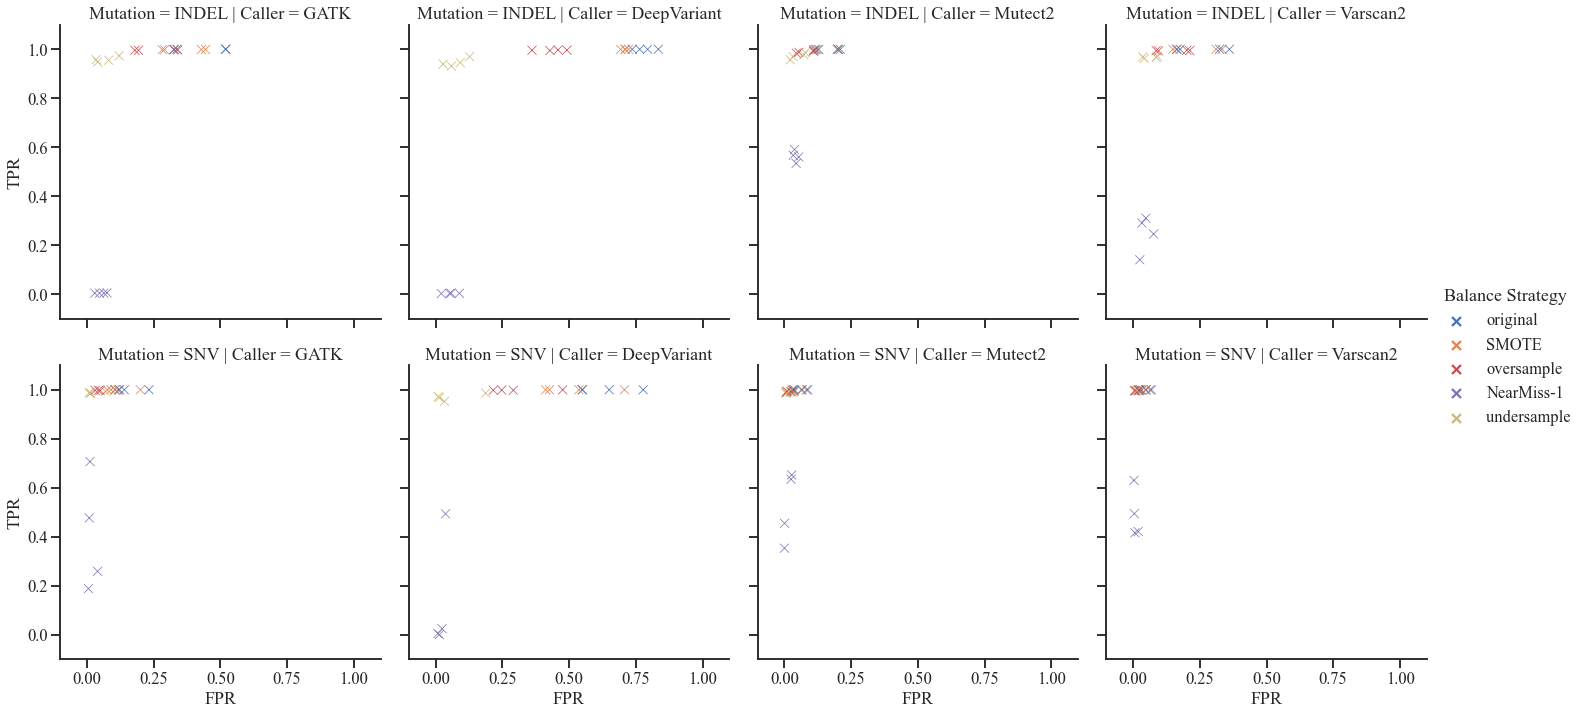

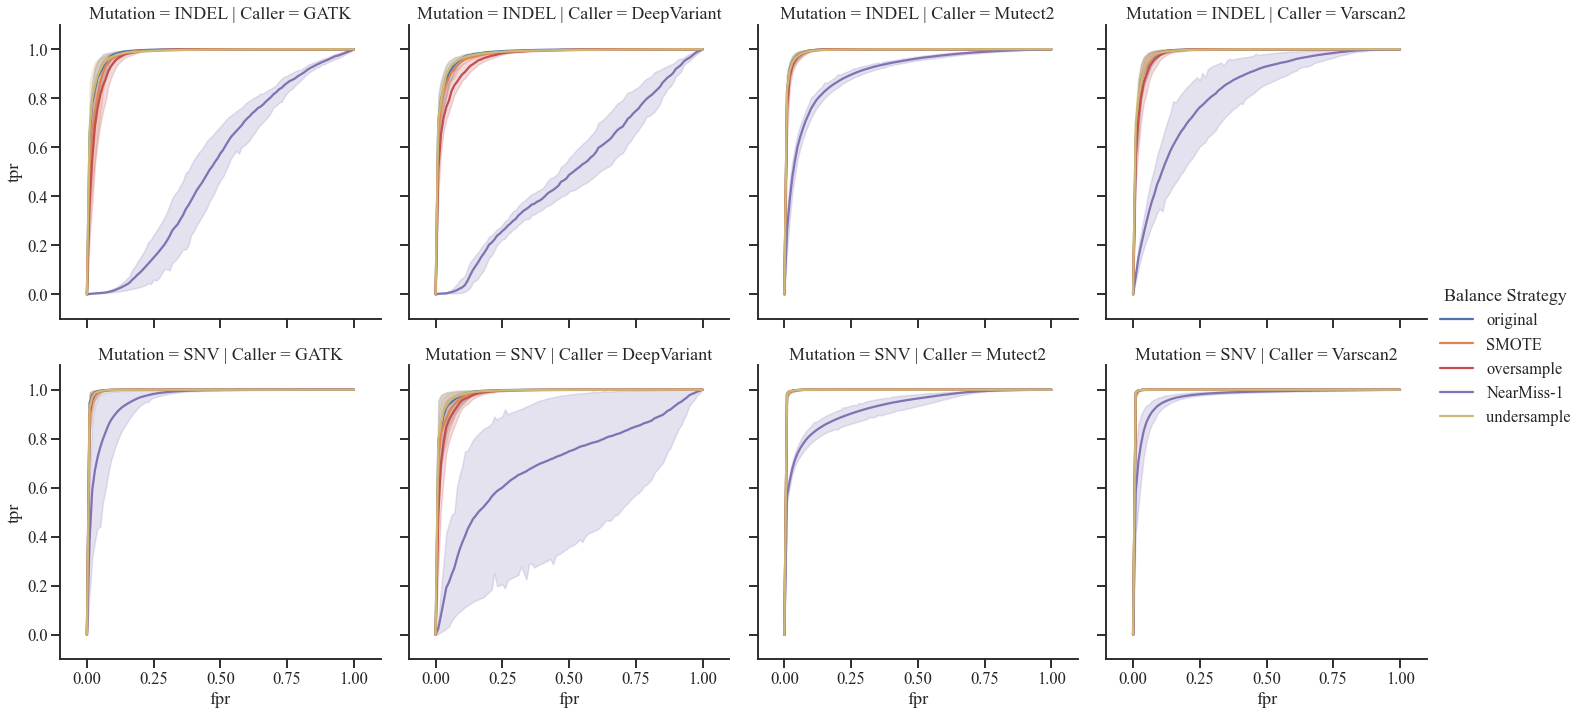

In [35]:
model = 'XGBoost' #
g = sns.relplot(data=metr_df.loc[(metr_df['Model']==model)&(metr_df['patient']!='HG007')], row='Mutation', col='Caller', kind='scatter', height=5, aspect=1,
    x='FPR', y='TPR', style='Balance Strategy', markers=['x']*len(order_strategy),
    hue='Balance Strategy', hue_order=list(order_strategy.values()), 
    palette=[snsdeep[i] for i in [0,1,3,4,8]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
plt.savefig('../plotpdf/reb_imb_roc_scatter_{}.pdf'.format(model))
plt.show()

g = sns.relplot(data=roc_df.loc[(roc_df['Model']==model)&(roc_df['patient']!='HG007')], row='Mutation', col='Caller', kind='line', height=5, aspect=1,
    x='fpr', y='tpr', hue='Balance Strategy', hue_order=list(order_strategy.values()),
    palette=[snsdeep[i] for i in [0,1,3,4,8]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
plt.savefig('../plotpdf/reb_imb_roc_line_{}.pdf'.format(model))
plt.show()

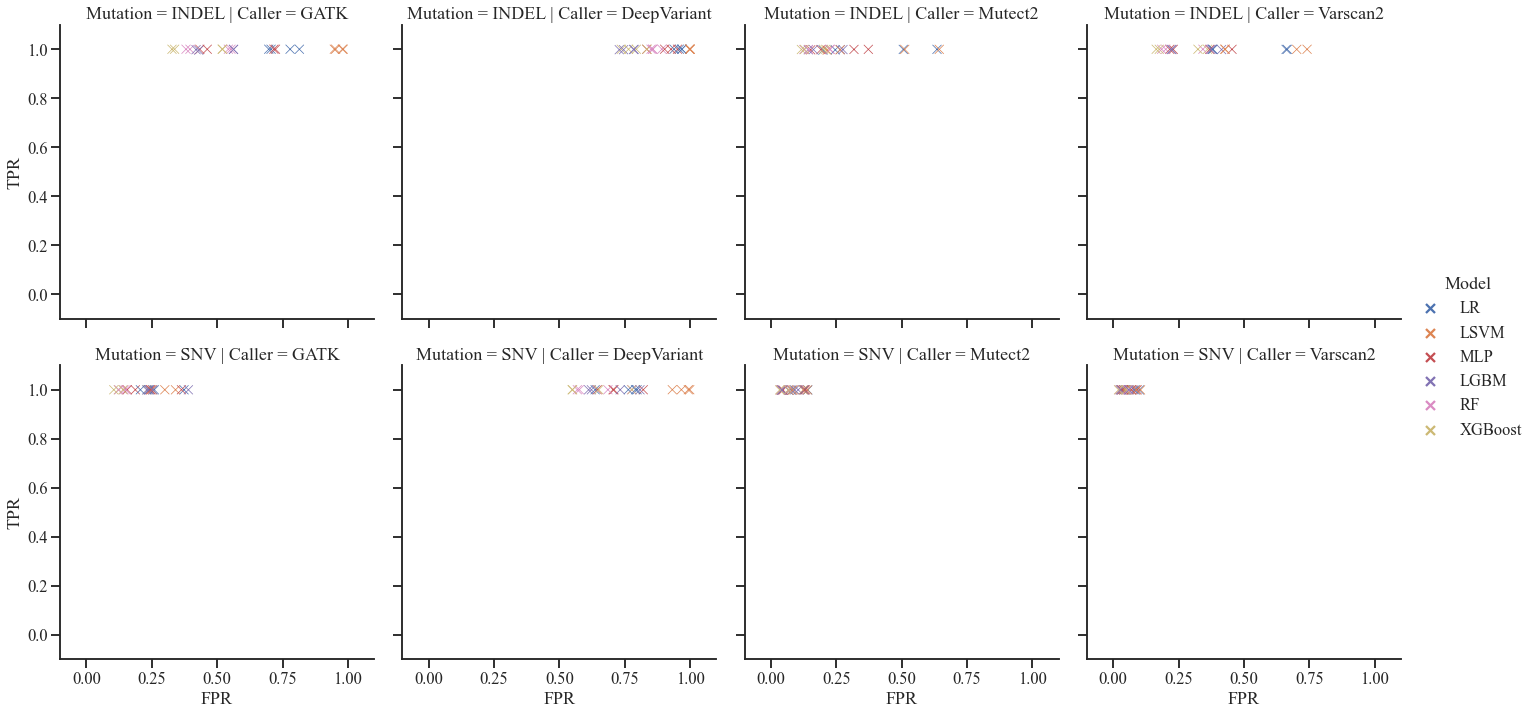

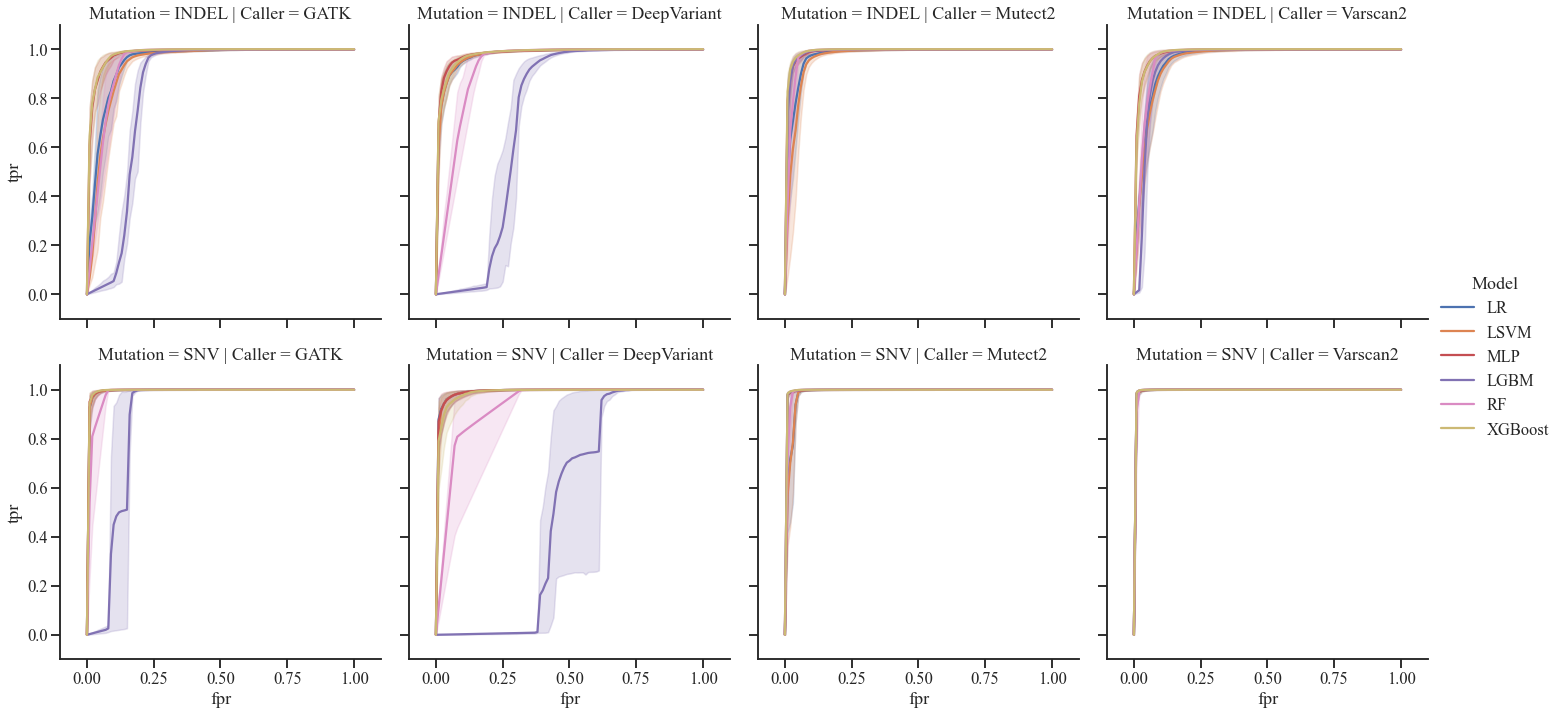

In [37]:
strategy = 'original' #
g = sns.relplot(data=metr_df.loc[(metr_df['Balance Strategy']==strategy)&(metr_df['patient']!='HG007')], row='Mutation', col='Caller', kind='scatter', height=5, aspect=1,
    x='FPR', y='TPR', style='Model', markers=['x']*len(order_model),
    hue='Model', hue_order=list(order_model.values()), 
    palette=[snsdeep[i] for i in [0,1,3,4,6,8]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
plt.savefig('../plotpdf/reb_imb_roc_scatter_{}.pdf'.format(strategy))
plt.show()

g = sns.relplot(data=roc_df.loc[(roc_df['Balance Strategy']==strategy)&(roc_df['patient']!='HG007')], row='Mutation', col='Caller', kind='line', height=5, aspect=1,
    x='fpr', y='tpr', hue='Model', hue_order=list(order_model.values()),
    palette=[snsdeep[i] for i in [0,1,3,4,6,8]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
plt.savefig('../plotpdf/reb_imb_roc_line_{}.pdf'.format(strategy))
plt.show()

In [38]:
metr_df

,AUC,AUPRC,AUPRG,ACC,BACC,MCC,F1-score,G1-score,NPV,FDR,...,software,mutation,patient,balance_strategy,depth,TPR,Caller,Model,Balance Strategy,Mutation
logireg,0.955261,0.999910,0.161133,0.943624,0.904005,0.134684,0.970956,0.044175,0.022667,0.000217,...,gatk,indel,HG001,randomunder,30X,0.943744,GATK,LR,undersample,INDEL
lsvm,0.953034,0.999905,0.118189,0.948618,0.903740,0.140503,0.973597,0.047967,0.024673,0.000225,...,gatk,indel,HG001,randomunder,30X,0.948754,GATK,LSVM,undersample,INDEL
nn,0.973164,0.999948,0.219522,0.964738,0.922875,0.175172,0.982028,0.070036,0.036468,0.000186,...,gatk,indel,HG001,randomunder,30X,0.964864,GATK,MLP,undersample,INDEL
rf,0.980776,0.999960,0.222721,0.956978,0.941808,0.166588,0.977984,0.060971,0.031522,0.000116,...,gatk,indel,HG001,randomunder,30X,0.957023,GATK,RF,undersample,INDEL
xgbdef,0.978264,0.999959,0.339553,0.954877,0.936608,0.161077,0.976885,0.057805,0.029842,0.000129,...,gatk,indel,HG001,randomunder,30X,0.954933,GATK,XGBoost,undersample,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lsvm,0.997409,0.999966,0.968396,0.998769,0.967715,0.934099,0.999379,0.934719,0.933377,0.000608,...,varscan,snp,HG007,original,30X,0.999365,Varscan2,LSVM,original,SNV
nn,0.999288,0.999988,0.985045,0.999123,0.961575,0.952018,0.999558,0.951992,0.982517,0.000729,...,varscan,snp,HG007,original,30X,0.999844,Varscan2,MLP,original,SNV
rf,0.997294,0.999949,0.987261,0.999350,0.977657,0.964836,0.999672,0.965115,0.974875,0.000422,...,varscan,snp,HG007,original,30X,0.999766,Varscan2,RF,original,SNV
xgbdef,0.999402,0.999993,0.988304,0.999400,0.979976,0.967609,0.999697,0.967880,0.975707,0.000378,...,varscan,snp,HG007,original,30X,0.999773,Varscan2,XGBoost,original,SNV


## 3. 仅注释后的特征的以上所有图片和数据

3.2 输出各个模型章节2和3的比较结果

In [53]:
alias_dict = {**order_caller,**order_model,**order_strategy,**order_mutation}
fnvc_metr_df = pd.read_pickle('../plotdata/reb_imb_metr_df.pkl')
select_row = ((fnvc_metr_df['software']=='gatk') | (fnvc_metr_df['software']=='mutect2')) & (fnvc_metr_df['balance_strategy']=='original') & (fnvc_metr_df['patient']!='HG007')
fnvc_metr_df = fnvc_metr_df.loc[select_row]
fnvc_metr_df['Feature Set'] = 'FNVC'
rawfeat_metr_df = pd.read_pickle('../plotdata/rawfeat_imb_metr_df.pkl')
rawfeat_metr_df['Feature Set'] = 'Annot'
metr_df = pd.concat((fnvc_metr_df, rawfeat_metr_df))
metr_df['TPR'] = 1 - metr_df['FNR']
metr_df[['Model','Caller','Mutation','Balance Strategy']] = metr_df[['model','software','mutation','balance_strategy']].applymap(lambda x: alias_dict[x])
metr_df_pp = metr_df.groupby(by=['Caller','Model','Balance Strategy','Mutation','patient','Feature Set']).mean()
metr_df_mn = metr_df.groupby(by=['Caller','Model','Balance Strategy','Mutation','Feature Set']).mean()
metr_df_sd = metr_df.groupby(by=['Caller','Model','Balance Strategy','Mutation','Feature Set']).std()
dfs_to_sheet([metr_df, metr_df_pp, metr_df_mn, metr_df_sd], ['raw', 'per patient', 'mean', 'std'], filename='feat_fnvc_vs_annot.xlsx', root_path=TAB_PATH)


In [52]:
metr_df_pp

AUC  \
Caller  Model   Balance Strategy Mutation patient Feature Set             
GATK    LGBM    original         INDEL    HG001   Annot        0.780289   
                                                  FNVC         0.827908   
                                          HG003   Annot        0.750030   
                                                  FNVC         0.820167   
                                          HG004   Annot        0.772007   
...                                                                 ...   
Mutect2 XGBoost original         SNV      HG003   FNVC         0.999599   
                                          HG004   Annot        0.997669   
                                                  FNVC         0.999722   
                                          HG006   Annot        0.992235   
                                                  FNVC         0.999190   

                                                                  AUPRC  \
Caller  Model   Balance Strategy Mutation patient Feature Set             
GATK    LGBM    original         INDEL    HG001   Annot        0.998987   
                                                  FNVC         0.999024   
                                          HG003   Annot        0.997042   
                                                  FNVC         0.998652   
                                          HG004   Annot        0.997742   
...                                                                 ...   
Mutect2 XGBoost original         SNV      HG003   FNVC         0.999987   
                                          HG004   Annot        0.999908   
                                                  FNVC         0.999992   
                                          HG006   Annot        0.999898   
                                                  FNVC         0.999990   

                                                                  AUPRG  \
Caller  Model   Balance Strategy Mutation patient Feature Set             
GATK    LGBM    original         INDEL    HG001   Annot        0.167379   
                                                  FNVC         0.372515   
                                          HG003   Annot        0.255034   
                                                  FNVC         0.335663   
                                          HG004   Annot        0.271835   
...                                                                 ...   
Mutect2 XGBoost original         SNV      HG003   FNVC         0.989982   
                                          HG004   Annot        0.978988   
                                                  FNVC         0.992071   
                                          HG006   Annot        0.944514   
                                                  FNVC         0.965373   

                                                                    ACC  \
Caller  Model   Balance Strategy Mutation patient Feature Set             
GATK    LGBM    original         INDEL    HG001   Annot        0.997639   
                                                  FNVC         0.998255   
                                          HG003   Annot        0.996736   
                                                  FNVC         0.994810   
                                          HG004   Annot        0.997135   
...                                                                 ...   
Mutect2 XGBoost original         SNV      HG003   FNVC         0.998150   
                                          HG004   Annot        0.997857   
                                                  FNVC         0.998452   
                                          HG006   Annot        0.998594   
                                                  FNVC         0.999008   

                                                                   BACC  \
Caller  Model   Balance Strategy Mutation patient Feature Set             
GATK    LGBM  

### 3.2 章节2和章节3的对比AUC图

In [54]:
alias_dict = {**order_caller,**order_model,**order_strategy,**order_mutation}
fnvc_roc_df = pd.read_pickle(os.path.join(DATABASE_PATH, 'reb_imb_roc_df.pkl'))
select_row = ((fnvc_roc_df['software']=='gatk') | (fnvc_roc_df['software']=='mutect2')) & (fnvc_roc_df['balance_strategy']=='original') & (fnvc_roc_df['patient']!='HG007')
fnvc_roc_df = fnvc_roc_df.loc[select_row]
fnvc_roc_df['Feature Set'] = 'FNVC'
rawfeat_roc_df = pd.read_pickle(os.path.join(DATABASE_PATH, 'rawfeat_imb_roc_df.pkl'))
rawfeat_roc_df['Feature Set'] = 'Annot'
roc_df = pd.concat((fnvc_roc_df, rawfeat_roc_df))
roc_df[['Caller','Model','Balance Strategy','Mutation']] = roc_df[['software','model','balance_strategy','mutation']].applymap(lambda x: alias_dict[x])
roc_df

,fpr,tpr,model,software,mutation,patient,balance_strategy,depth,Feature Set,Caller,Model,Balance Strategy,Mutation
0,0.00,0.000000,logireg,gatk,indel,HG001,original,30X,FNVC,GATK,LR,original,INDEL
1,0.01,0.166091,logireg,gatk,indel,HG001,original,30X,FNVC,GATK,LR,original,INDEL
2,0.02,0.222738,logireg,gatk,indel,HG001,original,30X,FNVC,GATK,LR,original,INDEL
3,0.03,0.324570,logireg,gatk,indel,HG001,original,30X,FNVC,GATK,LR,original,INDEL
4,0.04,0.369704,logireg,gatk,indel,HG001,original,30X,FNVC,GATK,LR,original,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.999917,lgbdef,mutect2,snp,HG006,original,30X,Annot,Mutect2,LGBM,original,SNV
97,0.97,0.999917,lgbdef,mutect2,snp,HG006,original,30X,Annot,Mutect2,LGBM,original,SNV
98,0.98,0.999918,lgbdef,mutect2,snp,HG006,original,30X,Annot,Mutect2,LGBM,original,SNV
99,0.99,0.999918,lgbdef,mutect2,snp,HG006,original,30X,Annot,Mutect2,LGBM,original,SNV


In [60]:
set(roc_df.Model)

{'LGBM', 'LR', 'LSVM', 'MLP', 'RF', 'XGBoost'}

In [ ]:
for model in order_model.values():
    g = sns.relplot(data=metr_df.loc[metr_df['Model']==model], row='Mutation', col='Caller', kind='scatter', height=5, aspect=1,
        x='FPR', y='TPR', style='Feature Set', markers=['x']*2,
        hue='Feature Set', hue_order=['FNVC','Annot'], 
        palette=[snsdeep[i] for i in [0,1]])
    g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
    plt.savefig('../plotpdf/fnvc_vs_rawfeat_roc_scatter_{}.pdf'.format(model))
    plt.show()

    g = sns.relplot(data=roc_df.loc[roc_df['Model']==model], row='Mutation', col='Caller', kind='line', height=5, aspect=1,
        x='fpr', y='tpr', hue='Feature Set', hue_order=['FNVC','Annot'],
        palette=[snsdeep[i] for i in [0,1]])
    g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
    plt.savefig('../plotpdf/fnvc_vs_rawfeat_roc_line_{}.pdf'.format(model))
    plt.show()

    g = sns.relplot(data=metr_df.loc[metr_df['Model']==model], row='Mutation', col='Caller', kind='scatter', height=5, aspect=1,
        x='FPR', y='TPR', style='Feature Set', markers=['x']*2,
        hue='Feature Set', hue_order=['FNVC','Annot'], 
        palette=[snsdeep[i] for i in [0,1]])
    g.set(xlim=(-0.05,0.5), ylim=(0.5,1.05))
    plt.savefig('../plotpdf/fnvc_vs_rawfeat_roc_scatter_{}_55.pdf'.format(model))
    plt.show()

    g = sns.relplot(data=roc_df.loc[roc_df['Model']==model], row='Mutation', col='Caller', kind='line', height=5, aspect=1,
        x='fpr', y='tpr', hue='Feature Set', hue_order=['FNVC','Annot'],
        palette=[snsdeep[i] for i in [0,1]])
    g.set(xlim=(-0.05,0.5), ylim=(0.5,1.05))
    plt.savefig('../plotpdf/fnvc_vs_rawfeat_roc_line_{}_55.pdf'.format(model))
    plt.show()

# 1. workflow

# 2/3. balanced train testing on different imbalanced data

In [24]:
software = 'mutect2'
data2_df = load_from_pickle('release/data2_BTrImbTe_{}.pickle'.format(software), '../')
data2_df['ratio test'] = data2_df['ratio test'].astype(str)
data2_df['ratio test'] = data2_df['ratio test'].map(order_test)
data2_df['order_test'] = data2_df['ratio test'].apply(lambda x: list(order_test.values()).index(x))
data2_df['model'] = data2_df['model'].map(order_model)
data2_df['order_model'] = data2_df['model'].apply(lambda x: list(order_model.values()).index(x))
# data2_df

loading release/data2_BTrImbTe_mutect2.pickle from ../


In [25]:
dfs_to_sheet([data2_df], ['sheet'], '../tab/diff_ratio_testing_result_{}.xlsx'.format(software))

In [26]:
data21_df = data2_df.loc[data2_df['model']=='LR'].melt(id_vars=['model','seed','mutation','patient','ratio train','ratio test','depth','order_test','order_model'], value_vars=['AUC','MCC','BACC','F1-score','Sensitivity(Recall)','Specificity','Precision','AUPRC','OFO','G1-score'],value_name='values',var_name='metrics')
# data21_df

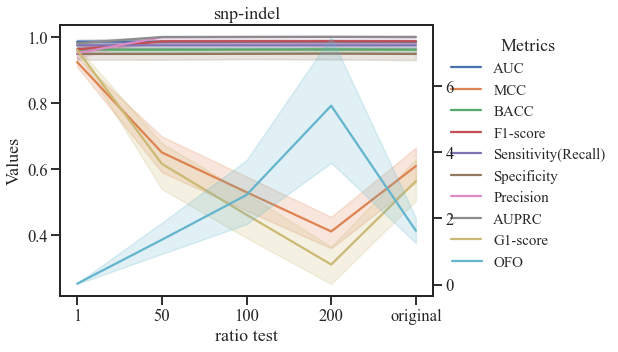

In [27]:
mutation = ['snp','indel']
plt.figure(figsize=(9,5))
plt.title('-'.join(mutation))
# g = sns.FacetGrid(data=data21_df, row='mutation', height=4, aspect=2)
ax = sns.lineplot(data=data21_df.loc[np.in1d(data21_df['mutation'], mutation)&(data21_df['metrics']!='OFO')],
    x='ratio test', y='values', hue='metrics', palette=[snsdeep[i] for i in range(9)])
ax.set_ylabel('Values')
plt.legend(title='Metrics', title_fontsize='medium',
    bbox_to_anchor=(1.5,1), loc='upper right', 
    fontsize='small', markerscale=0.5, frameon=False)
ax2 = ax.twinx()
sns.lineplot(data=data21_df.loc[np.in1d(data21_df['mutation'],mutation)&(data21_df['metrics']=='OFO')],
    x='ratio test', y='values', hue='metrics', palette=[snsdeep[i] for i in [9]], ax=ax2)
ax2.set_ylabel(None)
plt.legend(bbox_to_anchor=(1.28,0.2), loc='upper right',
    fontsize='small', markerscale=0.5, frameon=False)
plt.subplots_adjust(right=0.7)
plt.savefig('../fig/2_metr_30x_{}_{}.pdf'.format('-'.join(mutation), software))
plt.show()

/home/dawntown/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/dawntown/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


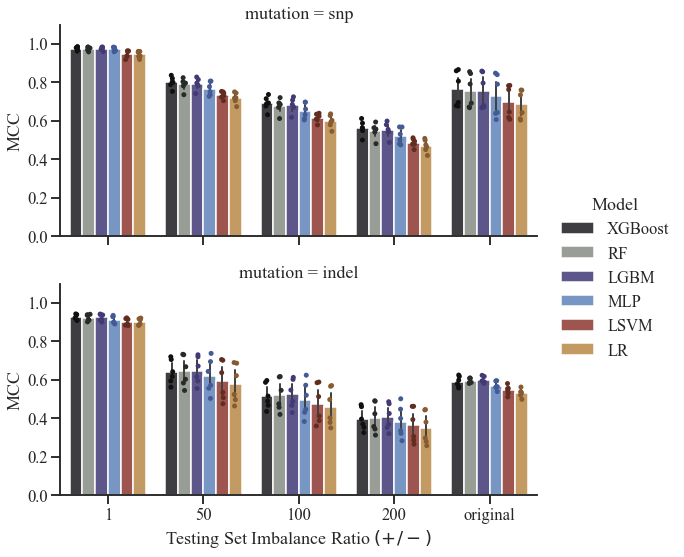

In [28]:
y_metrname = 'MCC'
g = sns.FacetGrid(data=data2_df, row='mutation', height=4, aspect=2)
g.map(sns.barplot, 'ratio test', y_metrname, 'model', hue_order=list(order_model.values())[::-1], 
    palette=get_pal(normal_dict, ['black','gray','purple','blue','red','orange']), errwidth=2)
g.add_legend(title='Model')
g.map(sns.stripplot, 'ratio test', y_metrname, 'model', hue_order=list(order_model.values())[::-1],
    palette=get_pal(dark_dict, ['black','gray','purple','blue','red','orange']), dodge=True)
g.set_xlabels('Testing Set Imbalance Ratio $(+/-)$')
g.set_ylabels(y_metrname)
plt.ylim((0,1.1))
plt.savefig('../fig/3_{}_{}.pdf'.format(y_metrname, software))
plt.show()


# 4. rebalanced training and original testing

In [8]:
software = 'varscan'
data4_df = load_from_pickle('./data4_RebTrImbTe_{}.pickle'.format(software))
data4_df = data4_df.loc[data4_df['balance strategy']!='balanced']
data4_df['model'] = data4_df['model'].map(order_model)
data4_df['balance strategy'] = data4_df['balance strategy'].map(order_strategy)
data4_df['order_model'] = data4_df['model'].apply(lambda x: list(order_model.values()).index(x))
data4_df['order_strategy'] = data4_df['balance strategy'].apply(lambda x: list(order_strategy.values()).index(x))
# data3_df

loading ./data4_RebTrImbTe_varscan.pickle from ./


In [36]:
dfs_to_sheet([data4_df], ['sheet'], '../tab/bal_imb_training_result_{}.xlsx'.format(software))

In [30]:
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, ttest_rel
def noparam_wrm(x,y):
    return [np.mean(x), np.std(x), np.mean(y), np.std(y), *ttest_rel(x,y,alternative='greater')]

In [8]:
y_metrname = 'MCC'
tab4in_list = []
for mut in ['indel','snp']:
    for model in ['LR','LSVM','MLP','RF','LGBM']:
        x = data4_df.loc[
            (data4_df['balance strategy']=='original')&
            (data4_df['mutation']==mut)&
            (data4_df['model']=='XGBoost')][y_metrname].values
        y = data4_df.loc[
            (data4_df['balance strategy']=='original')&
            (data4_df['mutation']==mut)&
            (data4_df['model']==model)][y_metrname].values
        # print(x.shape, y.shape)
        tab4in_list.append([mut,model,*noparam_wrm(x,y)])
tab4in = pd.DataFrame(np.array(tab4in_list), columns=['Mutation','Model','XGBoost Ave','XGBoost SD','Model Ave','Model SD','statistic','pvalue'])
# tab4in.to_excel('../plot/tab/Table4in.xlsx')

In [9]:
tab4in

,Mutation,Model,XGBoost Ave,XGBoost SD,Model Ave,Model SD,statistic,pvalue
0,indel,LR,0.7210833063676786,0.053791584726879366,0.4410547562026152,0.06362118784844632,25.789903897357565,8.185677129414995e-07
1,indel,LSVM,0.7210833063676786,0.053791584726879366,0.19445628051626274,0.04205654696522627,24.852053241882015,9.839157355966272e-07
2,indel,MLP,0.7210833063676786,0.053791584726879366,0.6073870731514669,0.08058602526639554,7.97124738398665,0.0002506483018377822
3,indel,RF,0.7210833063676786,0.053791584726879366,0.709829512977472,0.04842699514710638,2.2153142333511253,0.03879202994054309
4,indel,LGBM,0.7210833063676786,0.053791584726879366,0.49037476207395453,0.07333861696053773,12.783405281840684,2.606034558919199e-05
5,snp,LR,0.9019278498583824,0.028511803872459066,0.8074516153983637,0.0582311145990483,6.655101424484491,0.0005778148303697538
6,snp,LSVM,0.9019278498583824,0.028511803872459066,0.8048621386584465,0.050824186582390525,8.799762965032604,0.000157264539402722
7,snp,MLP,0.9019278498583824,0.028511803872459066,0.8609042816494896,0.036258782597203595,9.918738935834993,8.888340638796631e-05
8,snp,RF,0.9019278498583824,0.028511803872459066,0.8954235325957761,0.02672351085421549,2.991196414984569,0.015202725714292431
9,snp,LGBM,0.9019278498583824,0.028511803872459066,0.7358599657976742,0.05727145254034507,7.502696321761325,0.0003325703780234549


In [16]:
data4_df

,AUC,MCC,F1-score,AUPRC,OFO,G1-score,model,seed,mutation,patient,balance strategy,ratio test,depth,order_model,order_strategy
logireg,0.992677,0.699770,0.999543,0.999985,0.261819,0.694875,LR,0,snp,HG001,original,0,30X,0,0
lsvm,0.992846,0.706486,0.999553,0.999986,0.248368,0.701426,LSVM,0,snp,HG001,original,0,30X,1,0
nn,0.994642,0.785370,0.999670,0.999990,0.119475,0.779251,MLP,0,snp,HG001,original,0,30X,2,0
rf,0.959934,0.838029,0.999747,0.999865,0.070620,0.833385,RF,0,snp,HG001,original,0,30X,4,0
xgbdef,0.994415,0.842418,0.999753,0.999988,0.066031,0.837824,XGBoost,0,snp,HG001,original,0,30X,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lsvm,0.949145,0.147051,0.977861,0.999889,35.673640,0.052826,LSVM,0,indel,HG007,undersample,0,30X,1,4
nn,0.971828,0.194066,0.987382,0.999950,20.525210,0.088042,MLP,0,indel,HG007,undersample,0,30X,2,4
rf,0.980576,0.177599,0.983342,0.999965,25.798000,0.071602,RF,0,indel,HG007,undersample,0,30X,4,4
xgbdef,0.978299,0.183047,0.983945,0.999955,24.590909,0.074874,XGBoost,0,indel,HG007,undersample,0,30X,5,4


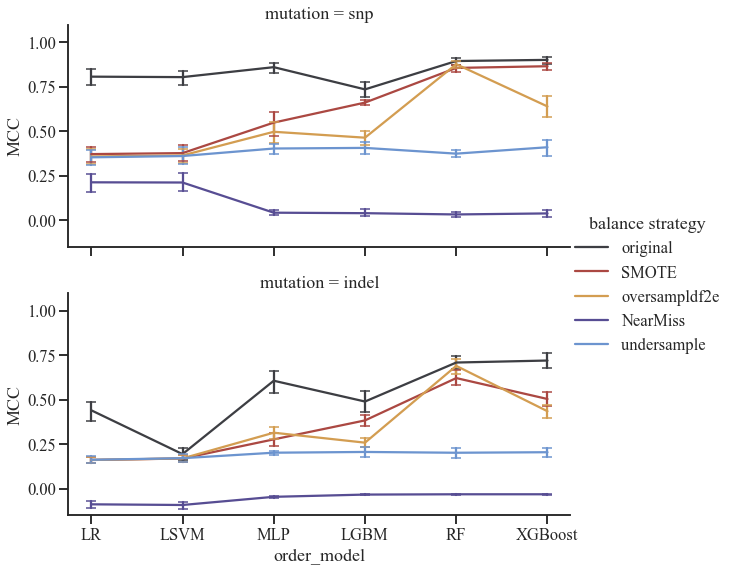

In [26]:
y_metrname = 'MCC'
# g = sns.FacetGrid()
sns.relplot(x='order_model', y=y_metrname, hue='balance strategy', data=data4_df, row='mutation', height=4, aspect=2, 
    hue_order=list(order_strategy.values()), kind='line', **{'markers':'o', 'dashes':(4,4)},
    palette=get_pal(normal_dict, ['black','red','orange','purple','blue']), err_style='bars', err_kws={'capsize':5, 'capthick':1.5})
plt.xticks(np.arange(len(order_model)), list(order_model.values()))
# g.add_legend(title='Balancing Strategy')
plt.ylim((-0.15,1.1))
# plt.savefig('../fig/4_{}_{}.pdf'.format(y_metrname, software))
plt.show()


# the filter performances based on various callers

# 5. ROC and decision points for diafferent filters and different callers

In [7]:
def nanlog10(x):
    if x > 0:
        return np.log10(x)
    else:
        return np.nan

In [16]:
data6_df_list = []
for caller in order_caller.keys():
    dataset = 'CV'
    data6_df_ = load_from_pickle('./release/data6_{}{}.pickle'.format(caller, dataset), DATABASE_PATH)
    data6_df_ = data6_df_.loc[data6_df_['filter'] != 'gf']
    data6_df_['filter'] = data6_df_['filter'].map(order_filter)
    data6_df_['depth'] = data6_df_['depth'].apply(lambda x: x.upper())
    data6_df_['order'] = data6_df_['patient'].apply(lambda x: order_patient[dataset].index(x))
    data6_df_['caller'] = order_caller[caller]
    data6_df_list.append(data6_df_)
data6_df = pd.concat(data6_df_list, axis=0)
data6_df['order_filter'] = data6_df['filter'].apply(lambda x: list(order_filter.values()).index(x))
data6_df['log OFO'] = data6_df['OFO'].apply(nanlog10)
# data6_df

loading ./release/data6_gatkCV.pickle from /mnt/d/Document/Master/ProjectRYY/plot
loading ./release/data6_varscanCV.pickle from /mnt/d/Document/Master/ProjectRYY/plot
loading ./release/data6_mutect2CV.pickle from /mnt/d/Document/Master/ProjectRYY/plot


In [17]:
data51_df = data6_df.copy()
data51_df['fpr'] = 1 - data51_df['Specificity']
data51_df['tpr'] = data51_df['Sensitivity(Recall)']
data51_df['filterpl'] = data51_df['filter'].apply(lambda x: x+'p')
data51_df = data51_df[['fpr','tpr','AUC','MCC','ACC','G1-score','Sensitivity(Recall)','Specificity','OFO','caller','mutation','patient','filter','filterpl','depth']]

In [18]:
order_caller = {'gatk':'GATK', 'mutect2':'Mutect2', 'varscan':'Varscan2'}
order_filterl = {'tc':'FNVC', 'garfield':'Garfield', 'vqsr':'VQSR'}
order_filterp = order_filter

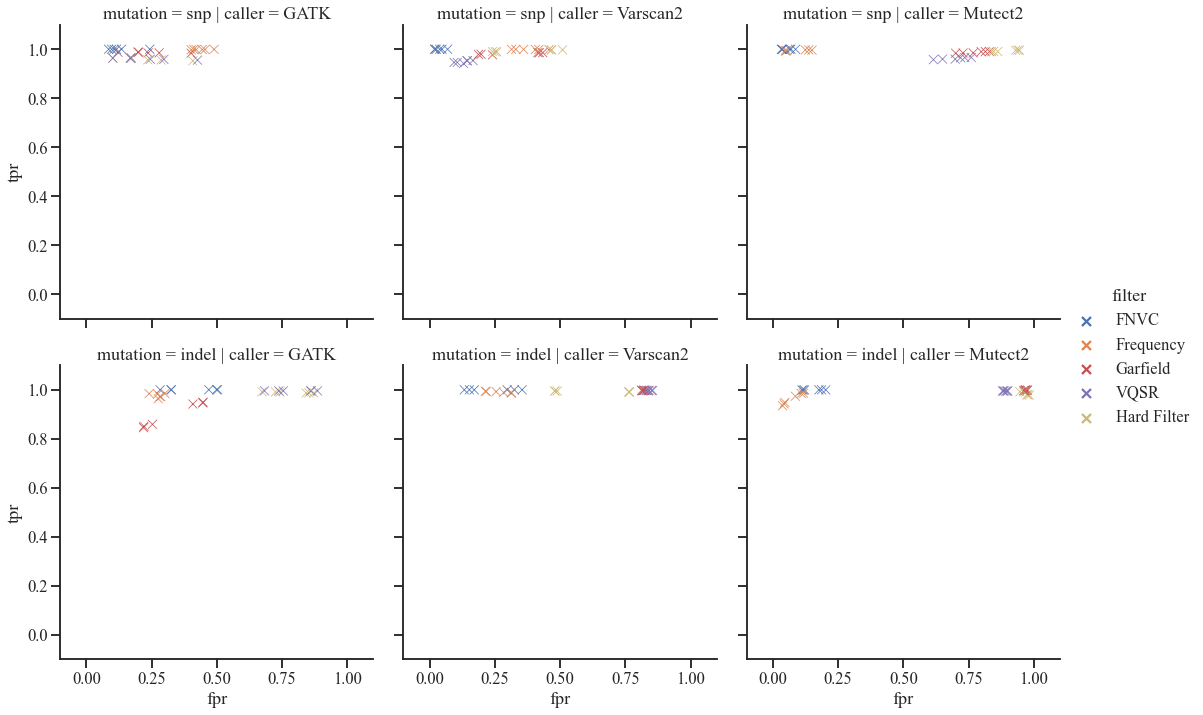

In [19]:
depth = '30X'
g = sns.relplot(data=data51_df.loc[data51_df['depth']==depth], row='mutation', col='caller', kind='scatter', height=5, aspect=1,
    x='fpr', y='tpr', style='filter', markers=['x']*len(order_filterp),
    hue='filter', hue_order=list(order_filterp.values()), 
    palette=[snsdeep[i] for i in [0,1,3,4,8]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
# g.savefig('../plot/fig/5_point_{}.pdf'.format(depth))

In [20]:
data52_df = load_from_pickle('./release/data5_forauc_{}_sparse.pickle'.format(depth), DATABASE_PATH)
data52_df.columns = ['fpr','tpr','caller','mutation','patient','filter']
data52_df['caller'] = data52_df['caller'].map(order_caller)
data52_df['filter'] = data52_df['filter'].map(order_filterl)
data52_df['filterpl'] = data52_df['filter'].apply(lambda x: x+'l')


loading ./release/data5_forauc_30X_sparse.pickle from /mnt/d/Document/Master/ProjectRYY/plot


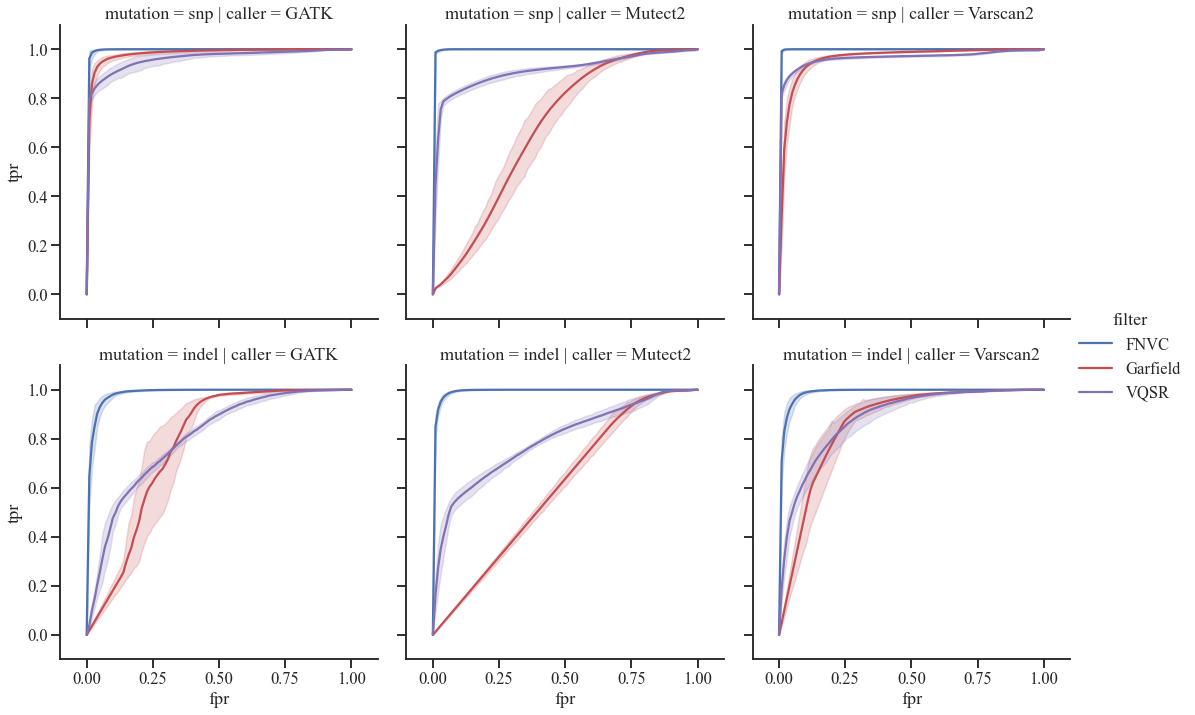

In [21]:
g = sns.relplot(data=data52_df, row='mutation', col='caller', kind='line', height=5, aspect=1,
    x='fpr', y='tpr', hue='filter', hue_order=list(order_filterl.values()),
    palette=[snsdeep[i] for i in [0,3,4]])
g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))
# g.savefig('../plot/fig/5_line_{}.pdf'.format(depth))

# 6. extra filter methods and our models based on the feature from different callers

In [23]:
data6_df['True'] = data6_df[['TP','FN']].sum(axis=1)
data6_df['False'] = data6_df[['TN','FP']].sum(axis=1)
metr_out = ['depth','caller','patient','filter','True','False']
metr_alas = ['Depth','Software','Patient','Filter','True variants', 'False variants']
data6_df_tab2 = data6_df[metr_out]
data6_df_tab2.columns = metr_alas
tab2_pre = data6_df_tab2.groupby(by=['Depth','Software','Patient','Filter'],group_keys=['Depth','Software','Patient','Filter']).apply(np.sum, axis=0)[['True variants','False variants']]
tab2_pre['Ratio'] = tab2_pre['True variants'] / tab2_pre['False variants']

tab2_pcnum = tab2_pre[['True variants','False variants']].groupby(by=['Depth','Software','Patient']).apply(np.mean, axis=0)
tab2_alnum_mn = tab2_pre[['True variants','False variants']].groupby(by=['Depth','Software']).apply(np.mean, axis=0)
tab2_alnum_sd = tab2_pre[['True variants','False variants']].groupby(by=['Depth','Software']).apply(np.std, axis=0)
tab2_pcrat = tab2_pre['Ratio'].groupby(by=['Depth','Software','Patient']).apply(np.mean, axis=0)
tab2_alrat_mn = tab2_pre['Ratio'].groupby(by=['Depth','Software']).apply(np.mean, axis=0)
tab2_alrat_sd = tab2_pre['Ratio'].groupby(by=['Depth','Software']).apply(np.std, axis=0)

# dfs_to_sheet(
#     [tab2_pcnum,tab2_alnum_mn,tab2_alnum_sd,tab2_pcrat,tab2_alrat_mn,tab2_alrat_sd],
#     ['#Var','Ave #Var','SD #Var','%Var','Ave %Var','SD %Var'], '../plot/tab/Table2.xlsx')

In [24]:
metr_out = ['depth','mutation','caller','filter','AUC','MCC','G1-score','OFO','BACC','Sensitivity(Recall)','Specificity','AUPRC','F1-score','ACC','TN','FN','TP','FP']
metr_alas = ['Depth','Mutation','Software','Method','AUC','MCC','F1-minar','OFO','BACC','TPR','TNR','AUPRC','F1-major','ACC','TN','FN','TP','FP']
data6_df_tab4 = data6_df[metr_out]
data6_df_tab4.columns = metr_alas
tab4_mn = data6_df_tab4.groupby(by=['Depth','Mutation','Software','Method']).apply(np.mean, axis=0)
tab4_sd = data6_df_tab4.groupby(by=['Depth','Mutation','Software','Method']).apply(np.std, axis=0)
# dfs_to_sheet([tab4_mn,tab4_sd], ['average', 'standard variance'], '../plot/tab/Table5mut.xlsx')

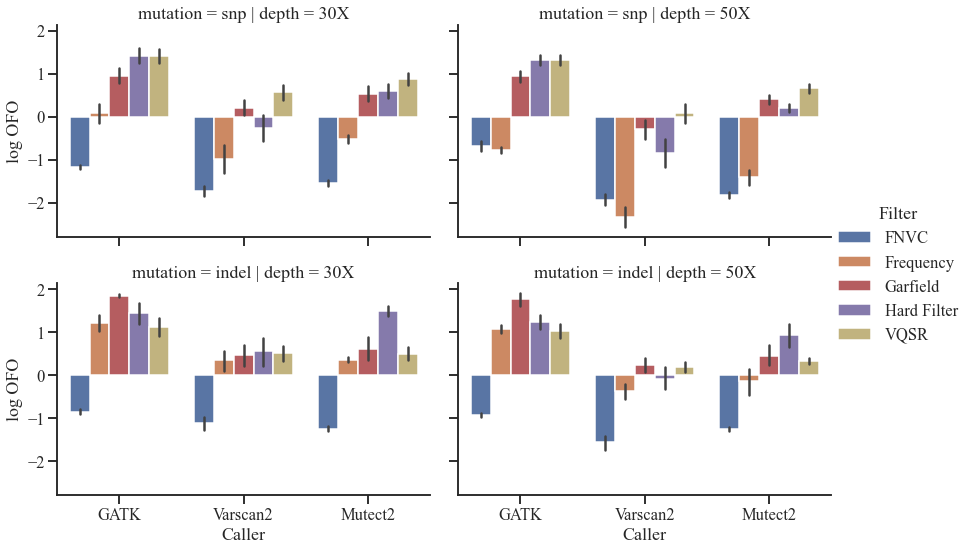

In [25]:
y_metrname = 'log OFO' # change it to MCC
g = sns.FacetGrid(data=data6_df, row='mutation', col='depth', height=4, aspect=1.5)
g.map(sns.barplot, 'caller', y_metrname, 'filter', errwidth=2.5,
    palette=[snsdeep[i] for i in [0,1,3,4,8]])
g.set_xlabels('Caller')
g.add_legend(title='Filter')
# g.savefig('../plot/fig/6_{}_bar.pdf'.format(y_metrname))
plt.show()

# 7. Group by frequency
(<0.2 inconsis, >0.2 consis)

In [8]:
data7_df_less = load_from_pickle('data7_less.pickle', './')
data7_df_greater = load_from_pickle('data7_greater.pickle', './')
data7_df_less['state'] = 'Low Frequency'
data7_df_greater['state'] = 'High Frequency'
data7_df = pd.concat((data7_df_less, data7_df_greater))
for i in range(10):
    data7_df[data7_df.columns[i]] = data7_df[data7_df.columns[i]].astype(float)
data7_df['caller'] = data7_df['caller'].map(order_caller2)
data7_df['filter'] = data7_df['filter'].map(order_filter_inconsis)
data7_df['order_filter'] = data7_df['filter'].apply(lambda x: list(order_filter.values()).index(x))
data7_df['log OFO'] = data7_df['OFO'].apply(nanlog10)

loading data7_less.pickle from ./
loading data7_greater.pickle from ./


In [27]:
data7_df['True'] = data7_df[['TP','FN']].sum(axis=1)
data7_df['False'] = data7_df[['TN','FP']].sum(axis=1)
metr_out = ['depth','state','caller','pcode','True','False']
metr_alas = ['Depth','State','Software','Patient','True variants', 'False variants']
data7_df_tab3 = data7_df[metr_out]
data7_df_tab3.columns = metr_alas

tab3_pre = data7_df_tab3.groupby(by=['Depth','State','Software','Patient']).apply(np.mean, axis=0)[['True variants','False variants']]
tab3_pre['Ratio'] = tab3_pre['True variants'] / tab3_pre['False variants']

tab3_pcnum = tab3_pre[['True variants','False variants']].groupby(by=['Depth','State','Software','Patient']).apply(np.mean, axis=0)
tab3_alnum_mn = tab3_pre[['True variants','False variants']].groupby(by=['Depth','State','Software']).apply(np.mean, axis=0)
tab3_alnum_sd = tab3_pre[['True variants','False variants']].groupby(by=['Depth','State','Software']).apply(np.std, axis=0)
tab3_pcrat = tab3_pre['Ratio'].groupby(by=['Depth','State','Software','Patient']).apply(np.mean, axis=0)
tab3_alrat_mn = tab3_pre['Ratio'].groupby(by=['Depth','State','Software']).apply(np.mean, axis=0)
tab3_alrat_sd = tab3_pre['Ratio'].groupby(by=['Depth','State','Software']).apply(np.std, axis=0)

# dfs_to_sheet(
#     [tab3_pcnum,tab3_alnum_mn,tab3_alnum_sd,tab3_pcrat,tab3_alrat_mn,tab3_alrat_sd],
#     ['#Var','Ave #Var','SD #Var','%Var','Ave %Var','SD %Var'], '../plot/tab/Table3.xlsx')


In [9]:
data7_df['True'] = data7_df[['TP','FN']].sum(axis=1)
data7_df['False'] = data7_df[['TN','FP']].sum(axis=1)
metr_out = ['depth','state','caller','filter','MCC','G1-score','OFO','BACC','Sensitivity(Recall)','Specificity']
metr_alas = ['Depth','State','Software','Method','MCC','F1-minor','OFO','BACC','TPR','TNR']
data7_df_tabfig6 = data7_df[metr_out]
data7_df_tabfig6.columns = metr_alas
tabfig6_mn = data7_df_tabfig6.groupby(by=['Depth','State','Software','Method']).apply(np.mean, axis=0)
tabfig6_sd = data7_df_tabfig6.groupby(by=['Depth','State','Software','Method']).apply(np.std, axis=0)
# dfs_to_sheet([tabfig6_mn,tabfig6_sd], ['average', 'standard variance'], '../plot/tab/Table_fig6.xlsx')
# tabfig6_mn

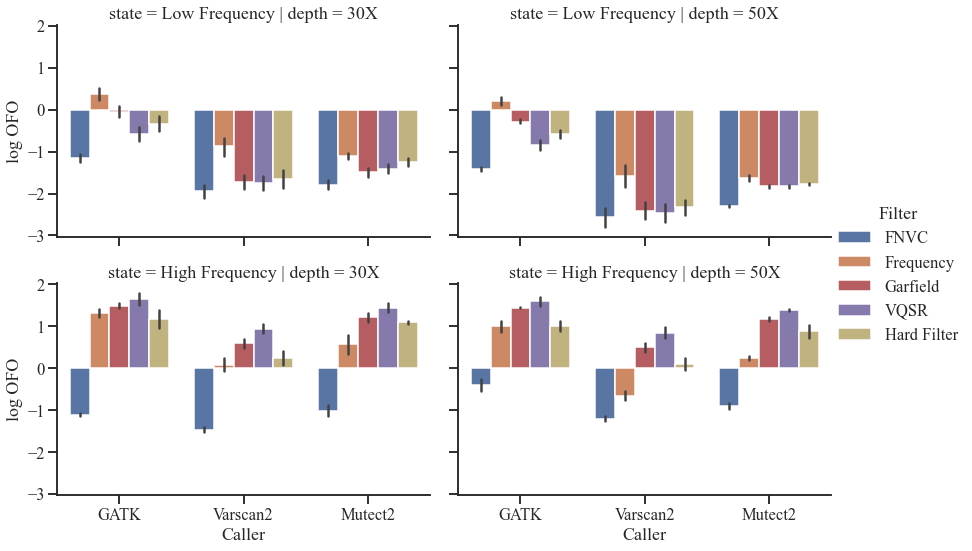

In [29]:
y_metrname = 'log OFO'
g = sns.FacetGrid(data=data7_df, row='state', col='depth', height=4, aspect=1.5)
g.map(sns.barplot, 'caller', y_metrname, 'filter', order=['GATK', 'Varscan2', 'Mutect2'],
    hue_order=list(order_filter.values()), palette=[snsdeep[i] for i in [0,1,3,4,8]], errwidth=2.5)

g.set_xlabels('Caller')
g.add_legend(title='Filter')
# g.set(ylim=(-0.1,1.1))
# g.savefig(path.join(PLOT_PATH, '7_{}.pdf'.format(y_metrname)))
plt.show()

# 8. consistant 

In [30]:
consis = 'consistent'
data8_df = load_from_pickle('./release/data8_{}.pickle'.format(consis), DATABASE_PATH)
for i in range(7):
    data8_df[data8_df.columns[i]] = data8_df[data8_df.columns[i]].astype(float)
data8_df['caller'] = data8_df['caller'].map(order_caller2)
data8_df['coding'] = data8_df['coding'].map(order_coding)
order_filter = order_filter_consis
data8_df = data8_df.loc[np.in1d(data8_df['filter'],['Gar','FNVC'])]
data8_df['filter'] = data8_df['filter'].map(order_filter)
data8_df['order_filter'] = data8_df['filter'].apply(lambda x: list(order_filter.values()).index(x))
data8_df['log OFO'] = data8_df['OFO'].apply(nanlog10)
# data6_df

loading ./release/data8_consistent.pickle from /mnt/d/Document/Master/ProjectRYY/plot


In [31]:
metr_out = ['depth','coding','caller','filter','MCC','G1-score','OFO','BACC','Sensitivity(Recall)','Specificity']
metr_alas = ['Depth','Region','Software','Method','MCC','F1-minar','OFO','BACC','TPR','TNR']
data8_df_excel = data8_df[metr_out]
data8_df_excel.columns = metr_alas
data81_mn = data8_df_excel.groupby(by=['Depth','Region','Software','Method']).apply(np.mean, axis=0)
data81_sd = data8_df_excel.groupby(by=['Depth','Region','Software','Method']).apply(np.std, axis=0)
data82_mn = data8_df_excel.groupby(by=['Depth','Software','Method']).apply(np.mean, axis=0)
data82_sd = data8_df_excel.groupby(by=['Depth','Software','Method']).apply(np.std, axis=0)
# dfs_to_sheet([data81_mn,data81_sd,data82_mn,data82_sd], ['average', 'standard variance','average (all)', 'standard variance (all)'], '../plot/tab/Table5_{}.xlsx'.format(consis))

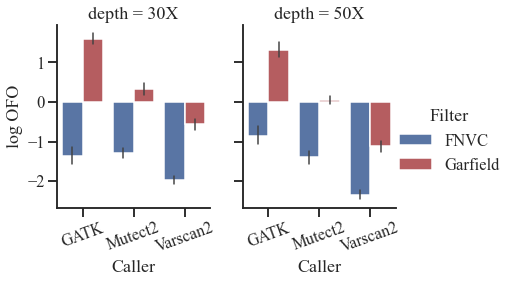

In [32]:
y_metrname = 'log OFO'
g = sns.FacetGrid(data=data8_df, col='depth', height=4, aspect=0.75)
g.map(sns.barplot, 'caller', y_metrname, 'filter', order=list(order_caller.values()),
    hue_order=list(order_filter.values()), palette=[snsdeep[i] for i in [0,3]], errwidth=1.5)
for ax in g.axes.flat:
    ax.set_xticks(np.arange(len(order_caller)))
    ax.set_xticklabels(list(order_caller.values()))
    for label in ax.get_xticklabels():
        label.set_rotation(20)
g.set_xlabels('Caller')
g.add_legend(title='Filter')
# g.set(ylim=(0,1.3))
g.savefig(path.join(PLOT_PATH, '8_{}_{}.pdf'.format(consis, y_metrname)))
plt.show()

# 9. inconsistent region, all callers

In [35]:
consis = 'inconsistent'
data9_df = load_from_pickle('./release/data8_{}.pickle'.format(consis), DATABASE_PATH)
for i in range(7):
    data9_df[data9_df.columns[i]] = data9_df[data9_df.columns[i]].astype(float)
data9_df['caller'] = data9_df['caller'].map(order_caller2)
data9_df['coding'] = data9_df['coding'].map(order_coding)
order_filter = order_filter_inconsis
data9_df['filter'] = data9_df['filter'].map(order_filter)
data9_df['order_filter'] = data9_df['filter'].apply(lambda x: list(order_filter.values()).index(x))
data9_df['log OFO'] = data9_df['OFO'].apply(nanlog10)
# data6_df

loading ./release/data8_inconsistent.pickle from /mnt/d/Document/Master/ProjectRYY/plot


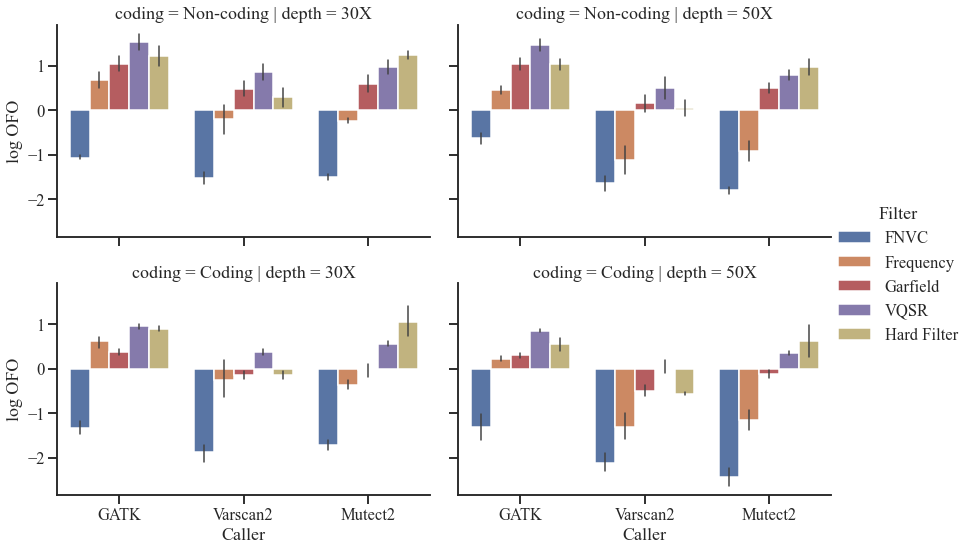

In [36]:
y_metrname = 'log OFO'
g = sns.FacetGrid(data=data9_df, row='coding', col='depth', height=4, aspect=1.5)
g.map(sns.barplot, 'caller', y_metrname, 'filter', order=['GATK', 'Varscan2', 'Mutect2'],
    hue_order=list(order_filter.values()), palette=[snsdeep[i] for i in [0,1,3,4,8]], errwidth=1.5)
g.set_xlabels('Caller')
g.add_legend(title='Filter')
# g.set(ylim=(-0.8,1.3))
# g.savefig(path.join(PLOT_PATH, '6_{}_{}.pdf'.format(consis, y_metrname)))
plt.show()

# suppl 1. importance score

In [37]:
gatk_feature = {'MQ':0, 'MQRankSum':1, 'MQ0':2, 'MBQ':3, 'BaseQRankSum':4, 'MFRL':5, 'MPOS':6, 'ReadPosRankSum':7, 'RPA':8, 'RPA2':9, 'RU':10, 'SOR':11, 'FS':12, 'QD':13, 'ExcessHet':14, 'GQ_MEAN':15, 'AS_SB_TABLE':16, 'AS_UNIQ_ALT_READ_COUNT':17, 'AF':18, 'CT':19}
varscan_feature = {'MQ':0, 'MQRankSum':1, 'MQ0':2, 'MBQ':3, 'BaseQRankSum':4, 'MFRL':5, 'MPOS':6, 'ReadPosRankSum':7, 'RPA':8, 'RPA2':9, 'RU':10, 'SOR':11, 'FS':12, 'GQ_MEAN':13, 'AS_SB_TABLE':14, 'AS_UNIQ_ALT_READ_COUNT':15, 'AF':16, 'CT':17}
mutect2_feature = {'MQ':0, 'MQRankSum':1, 'MQ0':2, 'MBQ':3, 'BaseQRankSum':4, 'MFRL':5, 'MPOS':6, 'ReadPosRankSum':7, 'RPA':8, 'RPA2':9, 'RU':10, 'SOR':11, 'FS':12, 'AS_SB_TABLE':13, 'AS_UNIQ_ALT_READ_COUNT':14, 'AF':15, 'CT':16}
gatk_feat = {v:k for k,v in gatk_feature.items()}
varscan_feat = {v:k for k,v in varscan_feature.items()}
mutect2_feat = {v:k for k,v in mutect2_feature.items()}
feat_dict = {'gatk':gatk_feat, 'varscan':varscan_feat, 'mutect2':mutect2_feat}
order_feature = [
    'RPA', 'RPA2', 'RU', 'CT', 
    'MBQ', 'MQRankSum', 'MPOS', 'ReadPosRankSum', 'SOR', 'FS', 'QD', 'ExcessHet',
    'MQ', 'MQ0', 'MQRankSum', 'GQ_MEAN', 'AS_UNIQ_ALT_READ_COUNT', 'AS_SB_TABLE', 'MFRL', 'AF']
source = [*['Sequence context']*4, *['Sequencing experiment']*8 ,*['Bioinformatics']*8]
source_feature = {k:v for k,v in zip(order_feature, source)}

In [38]:
dataS1_list = []
for caller in ['gatk','mutect2','varscan']:
    dataS1_df_ = pd.melt(load_from_pickle('./release/dataS1_imp_{}.pickle'.format(caller), DATABASE_PATH), id_vars=['caller','mutation','pcode'], var_name='feature', value_name='importance score')
    dataS1_df_['feature'] = dataS1_df_['feature'].map(feat_dict[caller])
    
    dataS1_list.append(dataS1_df_)
dataS1_df = pd.concat(dataS1_list)
dataS1_df['source'] = dataS1_df['feature'].map(source_feature)

loading ./release/dataS1_imp_gatk.pickle from /mnt/d/Document/Master/ProjectRYY/plot
loading ./release/dataS1_imp_mutect2.pickle from /mnt/d/Document/Master/ProjectRYY/plot
loading ./release/dataS1_imp_varscan.pickle from /mnt/d/Document/Master/ProjectRYY/plot


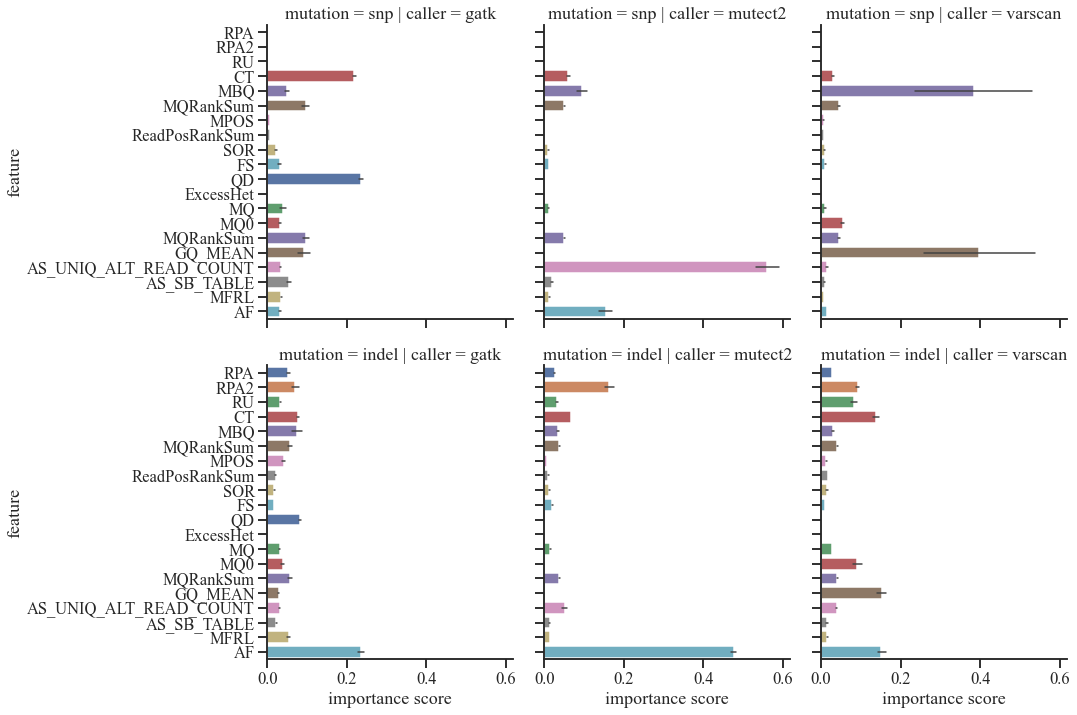

In [39]:
sns.catplot(data=dataS1_df, row='mutation', col='caller', kind='bar', height=5, aspect=1,
    x='importance score', y='feature', order=order_feature,
    color='blue', palette='deep', errwidth=1.5)
# plt.savefig('../plot/fig/S1_featimp.pdf')

# Suppl 2. Load total variances of three caller

In [7]:
count_df = load_from_pickle('dataS2_count.pickle')

loading dataS2_count.pickle from ./


In [8]:
dfs_to_sheet([count_df], ['individual count'], '../tab/Table_supp2add.xlsx')

# Convert all pickle to CSV

In [19]:
from glob import glob

In [20]:
pkls = glob('./*.pickle')

In [23]:
for pkl in pkls:
    pkl_df = load_from_pickle(pkl)
    pkl_df.to_csv('./pickle2csv/'+pkl+'.csv')

loading ./data2_50BTrImbTe_gatk.pickle from ./
loading ./data2_BTrImbTe.pickle from ./
loading ./data2_BTrImbTe_gatk.pickle from ./
loading ./data2_BTrImbTe_mutect2.pickle from ./
loading ./data2_BTrImbTe_varscan.pickle from ./
loading ./data4_RebTrImbTe.pickle from ./
loading ./data4_RebTrImbTe_gatk.pickle from ./
loading ./data4_RebTrImbTe_mutect2.pickle from ./
loading ./data4_RebTrImbTe_varscan.pickle from ./
loading ./data5_forauc_30X_sparse.pickle from ./
loading ./data5_forauc_50X_sparse.pickle from ./
loading ./data6_gatkCV.pickle from ./
loading ./data6_mutect2CV.pickle from ./
loading ./data6_varscanCV.pickle from ./
loading ./data7_greater.pickle from ./
loading ./data7_less.pickle from ./
loading ./data8_consistent.pickle from ./
loading ./data8_inconsistent.pickle from ./
loading ./dataS1_imp_gatk.pickle from ./
loading ./dataS1_imp_mutect2.pickle from ./
loading ./dataS1_imp_varscan.pickle from ./
loading ./dataS2_count.pickle from ./
